In [ ]:
!pip install -q -U einops datasets matplotlib tqdm pytz icecream

import math

import copy
import os

import csv

from pathlib import Path
from inspect import isfunction
from functools import partial

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from plotly.subplots import make_subplots
import plotly.graph_objs as go

from tqdm.auto import tqdm

from datetime import datetime
from pytz import timezone

from einops import rearrange

from scipy.stats import entropy
from scipy.linalg import sqrtm

from PIL import Image, ImageDraw

from IPython.display import HTML

import torch
from torch import nn, einsum
import torch.nn.functional as F
from torch.utils.data import random_split, Dataset, DataLoader, Subset
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

import cv2
from skimage.metrics import structural_similarity as ssim

import torchvision.models as models
import torchvision.transforms as transforms
from torchvision import utils
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
from torchvision.utils import save_image

from google.colab import files
from google.cloud import storage

from datasets import load_dataset

import pickle

import json

import glob

from icecream import ic

%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.3/502.3 kB 46.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 67.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 20.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DOWNLOAD_DATA = False

In [ ]:
if DOWNLOAD_DATA:
    %cp kaggle.json /content/drive/MyDrive/kaggle
    ! mkdir ~/.kaggle
    %cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/
    ! chmod 600 ~/.kaggle/kaggle.json
    %cd /content/drive/MyDrive/cv-final-project/data
    ! kaggle competitions download -c histopathologic-cancer-detection --force
    %cd /content

In [ ]:
! unzip /content/drive/MyDrive/cv-final-project/data/histopathologic-cancer-detection.zip > /dev/null

In [ ]:
labels_df = pd.read_csv('train_labels.csv')

malignant_labels_df = labels_df.loc[labels_df['label'] == 1]
non_malignant_labels_df = labels_df.loc[labels_df['label'] == 0]

In [ ]:
torch.manual_seed(12664675) # We create a manual seed

In [ ]:
class HistoDataset(Dataset):

    def __init__(self, data_dir, data_type='train', data_partition=None, split=None, seed=None, num_samples=None, **kwargs):
        ## Get image file names
        data_type_dir = os.path.join(data_dir, data_type) ## "Data dir" simply acts as a placeholder for the current directory, "data_type" defaults to "train", given it states the folder of avaialble data, and we do not have labels distincting the data in "test"

        if 'is_malignant' in kwargs:
            self.is_malignant = kwargs['is_malignant']
        else:
            # Default self.is_malignant to True
            self.is_malignant = True
        
        ## Change the file names based on whether we are asking for a malignant or non-malignant dataset
        self.labels_df = malignant_labels_df['id'] if self.is_malignant else non_malignant_labels_df['id']
        self.file_names = self.labels_df.values  

        ## If 'split' is provided split the data into train/test proportions
        if split is not None:
            assert 0.0 < split < 1.0, 'Split should be between 0.0 and 1.0'
            if seed is not None:
                np.random.seed(seed)
            np.random.shuffle(self.file_names)
            split_idx = int(len(self.file_names) * split)
            if data_partition == 'train':
                self.file_names = self.file_names[:split_idx]
            elif data_partition == 'eval':
                self.file_names = self.file_names[split_idx:]
            else:
                raise ValueError('\"data_partition\" invalid: should be \"train\" or \"test\"')

        ## Selects number of samples based on kwargs for number of samples to select, raises error if number of samples is greater than total number of files
        if num_samples is not None:
            if num_samples == 'all':
                pass
            elif num_samples > len(self.file_names):
                raise ValueError('\"num_samples\" cannot be larger than the total number of samples')
            else:
                self.file_names = self.file_names[:num_samples]

        ## Continuation of previous block, sets the number of samples as the length of file names (after being chosen by previous block)
        self.num_samples = len(self.file_names)

        ## Sets the parameterized transformations available to creating the dataset
        if 'transforms' in kwargs:
            self.transforms = kwargs['transforms']
        else:
            self.transforms = transforms.Compose([])

        ## Code block to return only the center crop 32x32 pixels that were used in the PCam dataset to identify whether to only use the cancer-identified pixels
        if 'malignant_crop' in kwargs:
            self.malignant_crop = kwargs['malignant_crop']
            self.return_malignant_section = True
            self.image_size = 32
        else:
            self.return_malignant_section = False
            self.image_size = 96

        ## Using kwargs sets whether to return a PIL or torch.tensor representation of the image
        if 'return_PIL' in kwargs:
            self.return_PIL = kwargs['return_PIL']
        else:
            self.return_PIL = True

        ## Sets number of channels in image, else defaults to 3 (R,G,B)
        if 'channels' in kwargs:
            self.channels = kwargs['channels']
        else:
            self.channels = 3

        '''
        Defines the reverse transforms to be used later on, depending on the number of desired channels and
            whether or not a PIL Image is wanting to be returned
        '''
        if 'reverse_transforms_list' in kwargs:
            intermediate_transform = Lambda(lambda t: rearrange(t, 'i j -> j i')) if self.channels == 1 else Lambda(lambda t: rearrange(t, 'i j k -> j k i'))
            self.reverse_transforms_list = kwargs['reverse_transforms_list']

            if 'reverse_return_PIL' in kwargs:
                self.reverse_return_PIL = kwargs['reverse_return_PIL']

            for idx in range(len(self.reverse_transforms_list)):
                if self.reverse_transforms_list[idx] == 'channels':
                    self.reverse_transforms_list[idx] = intermediate_transform

                elif self.reverse_transforms_list[idx] == 'reverse_return_PIL':
                    self.reverse_transforms_list[idx] = ToPILImage() if self.reverse_return_PIL else Compose([])

            self.reverse_transforms = Compose(self.reverse_transforms_list)
        else:
            self.reverse_transforms = None

        ## Choose indices for random samples, else use all samples if self.num_samples == len(self.file_names)
        self.files_choose = np.random.choice(self.file_names, 
                                             self.num_samples, 
                                             replace=False).tolist()

        ## Get all file pathes that make up the selected images in the dataset
        self.full_file_path = [os.path.join(data_type_dir, file_name + '.tif') for file_name in self.files_choose]

        ## Defines a pytorch.transforms functions to transform from PIL Image to PyTorch Tensor
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Open image, apply transforms and return with label
        image = Image.open(self.full_file_path[idx])  # Open Image with PIL
        
        if self.channels == 1:
            image = image.convert('L')

        if self.return_malignant_section:
            image = self.malignant_crop(image)

        image_tensor = self.transforms(image) # Apply set transformations to Image

        if self.return_PIL:
            return image
        else:
            return image_tensor

In [ ]:
malignant_crop = transforms.CenterCrop((32, 32)) # We only want the innermost, identifiable 32x32px region of tumor tissue

In [ ]:
## As stated in the DDPM paper, restricts the values of all pixels between [-1,1]
img_transforms = Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Lambda(lambda t: (2 * t) - 1)
    ]
)

In [ ]:
## torch implementation for reverse_transforms, moving values: [-1, 1] -> [1, 0]
reverse_transforms_list = [
    Lambda(lambda t: t.permute(1, 2, 0)),
    Lambda(lambda t: (t + 1) / 2),
    'channels', ## Will replace programatically based on whether using grayscale or RBG (1 or 3 channels)
    Lambda(lambda t: torch.clamp(t, 0, 1)),
    'reverse_return_PIL', ## Will replace programatically based on whether needing to return a PIL Image
]

In [ ]:
data_dir = '.'

In [ ]:
## Instantiate the dataset using malignant/non-malignant samples 
train_dataset = HistoDataset(data_dir=data_dir,
                             data_type='train',
                             data_partition='train',
                             split=0.9, 
                             seed=12664675, 
                             num_samples='all',
                             is_malignant=True,
                             malignant_crop=malignant_crop,
                             transforms=img_transforms,
                             reverse_transforms_list=reverse_transforms_list,
                             reverse_return_PIL=False,
                             return_PIL=True,
                             channels=3
)

In [ ]:
eval_dataset = HistoDataset(data_dir=data_dir, 
                            data_type='train',
                            data_partition='eval',
                            split=0.9, 
                            seed=12664675, 
                            num_samples='all', 
                            is_malignant=True,
                            malignant_crop=malignant_crop,
                            transforms=img_transforms,
                            reverse_transforms_list=reverse_transforms_list,
                            reverse_return_PIL=False,
                            return_PIL=True,
                            channels=3
)

The `denoise_model` will be our U-Net defined above. We'll employ the Huber loss between the true and the predicted noise.

## Define a PyTorch DataLoader

Here we define a regular PyTorch DataLoader, as well as creating variables to store information about the dataset (`image_size`, `channels`, and `batch_size`)

Finally, we define a `DataLoader` from the `HistoDataset` class created and instantiated previously

In [ ]:
image_size = train_dataset.image_size
channels = train_dataset.channels
batch_size = 128

Next, we define a function which we'll apply on-the-fly on the entire dataset. We use the `with_transform` [functionality](https://huggingface.co/docs/datasets/v2.2.1/en/package_reference/main_classes#datasets.Dataset.with_transform) for that. The function just applies some basic image preprocessing: random horizontal flips, rescaling and finally make them have values in the $[-1,1]$ range.

In [ ]:
## Changes the train/eval_dataset instance variable to return a torch.Tensor instead of a PILImage
train_dataset.return_PIL = False
eval_dataset.return_PIL = False

## Create train/eval_loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=True)

# UNet Associated Classes

---

## Base Block

In [ ]:
class BaseBlock(nn.Module):
    '''
    Base block for UNet with time embedding
    '''
    def __init__(self, in_ch, out_ch, tdim=512):
        super().__init__()
        self.t_mlp = nn.Linear(tdim, in_ch)
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_ch)        
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x, t):
        temb = self.t_mlp(t)
        temb = temb.reshape(*temb.shape, 1, 1)
        x = x + temb
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

## Encoder/Decoder Blocks

In [ ]:
class EncoderBlock(nn.Module):
    '''
    UNet encoder
    '''
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.base = BaseBlock(in_ch, out_ch)
        self.downsample = nn.MaxPool2d(2)
        
    def forward(self, x, t):
        x = self.base(x, t)
        x_down = self.downsample(x)
        return x_down, x # return x for Decoder

class DecoderBlock(nn.Module):
    '''
    UNet decoder
    '''
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.upsample = nn.ConvTranspose2d(in_ch, out_ch, 2, 2)
        self.base = BaseBlock(in_ch, out_ch)
        
    def forward(self, x, f, t):
        x = self.upsample(x)
        x = torch.cat([x, f], dim=1) # concat features from encoder
        x = self.base(x, t)
        return x

## Sinusodial Positional Embedding with (Optional) Self-Attention

In [ ]:
class SinusoidalPositionEmbedding(nn.Module):
    '''
    Transformer Sinusoidal Position(Time) Embedding in 'Attention is All You Need' paper
    '''
    def __init__(self, t_dim=512, device='cuda'):
        super().__init__()
        n = 10000
        self.w = 1. / torch.pow(n, 2 * torch.arange(t_dim // 2, device=device) / t_dim)
                
    def forward(self, t):
        t = t[:, None] * self.w[None, :]
        sin_t = torch.sin(t)
        cos_t = torch.cos(t)
        embedding = torch.stack([sin_t, cos_t], dim=-1).flatten(start_dim=1)
        return embedding

class SelfAttention(nn.Module):
    def __init__(self, channels, heads=4):
        super().__init__()
        self.channels = channels
        self.heads = heads
        self.mha = nn.MultiheadAttention(channels, heads, batch_first=True)
        self.layer_norm = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        batch_size, channels, height, width = x.shape
        x = x.view(batch_size, channels, -1).permute(0, 2, 1)
        x_ln = self.layer_norm(x)

        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        attention_value = attention_value.permute(0, 2, 1).view(batch_size, channels, height, width)

        return attention_value

## U-Net Class

In [ ]:
class UNet(nn.Module):
    def __init__(self, channels=3, attention_layers=(2, 4, 6, 8), t_dim=512):
        super().__init__()

        self.channels = channels
        self.attention_layers = attention_layers
        self.t_dim = t_dim

        # Time embedding
        self.t_mlp = nn.Sequential(
            SinusoidalPositionEmbedding(),
            nn.Linear(self.t_dim, self.t_dim),
        )

        # Encoder blocks
        self.enc_1 = EncoderBlock(self.channels, 64)
        self.sa_enc_1 = SelfAttention(64) if (1 in self.attention_layers) else nn.Identity()

        self.enc_2 = EncoderBlock(64, 128)
        self.sa_enc_2 = SelfAttention(128) if (2 in self.attention_layers) else nn.Identity()

        self.enc_3 = EncoderBlock(128, 256)
        self.sa_enc_3 = SelfAttention(256) if (3 in self.attention_layers) else nn.Identity()

        self.enc_4 = EncoderBlock(256, 512)
        self.sa_enc_4 = SelfAttention(512) if (4 in self.attention_layers) else nn.Identity()

        # Mid block
        self.mid_5 = BaseBlock(512, 1024)
        self.sa_mid_5 = SelfAttention(1024) if (5 in self.attention_layers) else nn.Identity()

        # Decoder blocks
        self.dec_6 = DecoderBlock(1024, 512)
        self.sa_dec_6 = SelfAttention(512) if (6 in self.attention_layers) else nn.Identity()

        self.dec_7 = DecoderBlock(512, 256)
        self.sa_dec_7 = SelfAttention(256) if (7 in self.attention_layers) else nn.Identity()

        self.dec_8 = DecoderBlock(256, 128)
        self.sa_dec_8 = SelfAttention(128) if (8 in self.attention_layers) else nn.Identity()

        self.dec_9 = DecoderBlock(128, 64)
        self.sa_dec_9 = SelfAttention(64) if (9 in self.attention_layers) else nn.Identity()

        # Final decode
        self.out = nn.Conv2d(64, self.channels, 1)
        
    def forward(self, x, t):
        t = self.t_mlp(t)
        
        x, r_1 = self.enc_1(x, t)
        x = self.sa_enc_1(x)

        x, r_2 = self.enc_2(x, t)
        x = self.sa_enc_2(x)

        x, r_3 = self.enc_3(x, t)
        x = self.sa_enc_3(x)

        x, r_4 = self.enc_4(x, t)
        x = self.sa_enc_4(x)

        x = self.mid_5(x, t)
        x = self.sa_mid_5(x)

        x = self.dec_6(x, r_4, t)
        x = self.sa_dec_6(x)

        x = self.dec_7(x, r_3, t)
        x = self.sa_dec_7(x)

        x = self.dec_8(x, r_2, t)
        x = self.sa_dec_8(x)

        x = self.dec_9(x, r_1, t)
        x = self.sa_dec_9(x)
        
        x = self.out(x)

        return x

# Diffusion Class

---

In [ ]:
class DiffusionModel():
    def __init__(self, channels=3, timesteps=1000, schedule='cosine_beta_schedule', loss_type='huber', attention_layers=(2, 4, 6, 8), beta_start=1e-4, beta_end=2e-2, s=0.008, image_size=32, device='cuda'):
        
        ## Instantiation attributes/objects from parameters
        self.timesteps = timesteps
        
        self.schedule = schedule
        self.attention_layers = attention_layers

        self.beta_start = beta_start
        self.beta_end = beta_end
        self.s = s

        self.channels = channels
        self.image_size = image_size
        self.device = device

        ## Obtain loss function based on what loss type is wanted
        self.loss_fn = {'huber': F.smooth_l1_loss, 'l1': F.l1_loss, 'l2': F.mse_loss}.get(loss_type)


        ## Derived attributes/objects
        self.beta = self.cosine_beta_schedule().to(self.device) if self.schedule == 'cosine_beta_schedule' else \
                    self.linear_beta_schedule().to(self.device)
        
        self.alpha = (1. - self.beta).to(self.device)
        self.alpha_bar = torch.cumprod(self.alpha, dim=0).to(self.device)

        self.unet = UNet(channels=self.channels, attention_layers=self.attention_layers)

    def cosine_beta_schedule(self):
        '''
        cosine beta schedule as proposed in https://arxiv.org/abs/2102.09672
        '''
        total_steps = self.timesteps + 1
        x = torch.linspace(0, self.timesteps, total_steps)
        alpha_bar = torch.pow(torch.cos(((x / self.timesteps) + self.s) / (1 + self.s) * torch.pi * 0.5), 2)
        alpha_bar = alpha_bar / alpha_bar[0]
        beta = 1 - (alpha_bar[1:] / alpha_bar[:-1])
        return torch.clip(beta, 0.0001, 0.9999)

    def linear_beta_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.timesteps)

    def forward_process(self, x_0, t):
        '''
        aka diffusion process
        '''
        eps = torch.randn_like(x_0, device=self.device)
        alpha_bar_t = self.alpha_bar[t].reshape(-1, *((1,) * (len(x_0.shape) - 1)))
        x_t = torch.sqrt(alpha_bar_t) * x_0 + torch.sqrt(1 - alpha_bar_t) * eps ## Reparameterization trick
        return x_t, eps

    def loss_function(self, x_0, t):
        '''
        simple MSE loss in DDPM paper
        '''
        x_t, eps = self.forward_process(x_0, t) ## t used as index
        eps_pred = self.unet(x_t, t.clone().to(dtype=torch.float32))
        loss = self.loss_fn(eps, eps_pred) ## huber loss
        return loss

    def reverse_transform(self, img):
        '''
        Returns an image transformed from
            [-1, 1] -> [0, 1] ([format in paper] -> [PIL image format])
            Automatically determines whether image is a torch.Tensor object and transforms based on type
        @param img: A torch.Tensor or numpy.ndarray image with values between [-1, 1]
        @return img: A numpy.ndarray image with values between [0, 1]
        '''
        if isinstance(img, torch.Tensor):
            img = img.detach().cpu().numpy()

        img = img.transpose(1, 2, 0)
        img = (img + 1) / 2
        img = np.clip(img, 0, 1)

        return img

    def show_images(self, imgs, reverse_transform=True):
        '''
        Plots outputs in format of generated images in a list or batches of images in numpy.array or torch.tensor format
            @param imgs: list, numpy.array, or torch.tensor of images
            @param reverse_transform: Reverses the transformed values of [-1, 1] back to [0, 1], as accepted by imshow and other plotting packages
        '''
        nums = len(imgs) if isinstance(imgs, list) else 1 if len(imgs.shape) == 3 else imgs.shape[0] # list or batch (of numpy or torch) of single or multiple images
        num_rows = (nums + 9) // 10
        num_cols = min(nums, 10)

        fig = plt.figure(figsize=(num_cols, num_rows))
        for idx in range(nums):
            img = imgs[idx] if nums > 1 else imgs

            if reverse_transform:
                img = self.reverse_transform(img)

            ax = plt.subplot(num_rows, num_cols, idx + 1)
            plt.imshow(img)
            plt.axis('off')
        plt.subplots_adjust(wspace=0.1, hspace=0.1)
        plt.show()

    @torch.no_grad()
    def sample_image(self, device='cuda'):
        '''
        Implementation of Algorithm 2 Sampling, for the same model across a single batch, across all timesteps
            @param device: Specifying which device to run processes on, defaults to 'cuda'
            @return x_p: For a single image processed, a torch.tensor of shape (timesteps x channels x height x width)
            @return x_img: Returns the last timestep of x_p, or a torch.tensor of shape (channels x height x width)
        '''

        x = torch.randn((1, self.channels, self.image_size, self.image_size), device=device)
        x_p = torch.empty((self.timesteps, self.channels, self.image_size, self.image_size))

        for t in tqdm(reversed(range(0, self.timesteps)), desc='Sampling timestep loop', total=self.timesteps):
            z = torch.randn_like(x) if t > 1 else torch.zeros_like(x)
            z = z.to(device)

            t_tensor = torch.tensor(t, dtype=torch.float32).unsqueeze(0).to(device)
            eps_pred = self.unet(x, t_tensor)

            x_pred = 1 / torch.sqrt(self.alpha[t]) * (x - self.beta[t] / torch.sqrt(1 - self.alpha_bar[t]) * eps_pred) + torch.sqrt(self.beta[t]) * z
            x = x_pred ## p(x_{t-1}|x_t)
            x_p[-t] = x.cpu()
            x_img = x_p[-1]

        return x_p, x_img

    @torch.no_grad()
    def sample_batch(self, batch_size=32, device='cuda', return_torch=False):
        '''
        Implementation of batched version for Algorithm 2 Sampling for the same model, across all batches.
            @param batch_size: Taking an int specifying the size per batch to process
            @param device: Specifying which device to run processes on, defaults to 'cuda'
            @return x_b: Batched torch.Tensor version of images processed across ALL timesteps
            @return x_b.numpy(): Batched numpy array version of images processed across ALL timesteps
            @return x_b_img: Batched torch.tensor single image
            @return x_b_img.numpy(): Batched np.array single image
        '''

        model = self.unet
        model.eval()

        x_b = torch.empty((batch_size, self.timesteps, self.channels, self.image_size, self.image_size))
        x_b_img = torch.empty((batch_size, self.channels, self.image_size, self.image_size))
        for idx in tqdm(range(batch_size), desc='Sampling batch loop', total=batch_size):
            x_p, x_img = self.sample_image()

            x_b[idx] = x_p
            x_b_img[idx] = x_img

        if return_torch:
            return x_b, x_b_img
        else:
            return x_b.numpy(), x_b_img.numpy()

# Train the Model

---

Next, we train the model in regular PyTorch fashion.

Below, we define the model, and move it to the GPU. We also define a standard optimizer (Adam).

The environment variables

```unix
TRAIN_MODEL
EVAL_MODEL
SAMPLE_MODEL
```

Each:

> Deciding whether to train the model

> Whether to evaluate the model on metrics to be shown later

> Whether to sample images from the trained model

Set whether to train a new `UNet` model or evaluate the models using metrics to be defined later on

In [ ]:
TRAIN_MODEL = True
EVAL_MODEL = False
SAMPLE_MODEL = True

In [ ]:
def save_diffusion(diffusion_model, save_str, save_to_drive, schedule, attention):

    if not save_to_drive:
        models_folder = Path('./models')
        models_folder.mkdir(exist_ok=True)

        model_save_path = str(models_folder / save_str) + '.pt'

    else:
        model_save_path = f'./drive/MyDrive/cv-final-project/ablation_study/ablation_trained/{schedule}/{attention}/' + save_str + '.pt'

    torch.save(diffusion_model, model_save_path)

In [ ]:
def save_loss(loss_list, save_str, save_to_drive, schedule, attention):
    
    if not save_to_drive:
        loss_list_folder = Path('./loss_list')
        loss_list_folder.mkdir(exist_ok=True)

        loss_list_save_path = str(loss_list_folder / save_str) + '.csv'

    else:
        loss_list_save_path = f'./drive/MyDrive/cv-final-project/ablation_study/ablation_trained/{schedule}/{attention}/' + save_str + '_loss_list.csv'

    loss_df = pd.DataFrame(loss_list)
    loss_df.to_csv(loss_list_save_path, header=False)

In [ ]:
def train_model(epochs=50,
                print_every_n_steps=100,
                save_diffusion_every_n_epochs=10,
                save_loss_every_n_epochs=1,
                schedule:str='linear_beta_schedule',
                attention:str='self_attention'
):

    ## Instantiate the diffusion class/model for whether to use any self-attention layers
    attention_layers = (2, 4, 6, 8) if attention == 'self_attention' else ();
    diffusion = DiffusionModel(attention_layers=attention_layers)
    model = diffusion.unet
    model.train()

    ## Instantiates device, moves model to device. and sets optimizer to Adam
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    optimizer = Adam(model.parameters(), lr=1e-5)

    model_channel_str = 'RGB_model_' if diffusion.channels == 3 else 'gray_model_'

    loss_list = []
    model.train()
    for epoch in range(1, epochs+1):
        for step, batch in enumerate(train_loader, 1):
            optimizer.zero_grad() ## Zeroes out optimizer

            batch_size = batch.shape[0] ## Defines batch_size as the first index of the batch.shape
            batch = batch.to(device) ## Sends batch to device

            t = torch.randint(0, diffusion.timesteps, (batch_size,), device=device).long() ## Algorithm 1 line 3: sample t uniformally for every example in the batch

            loss = diffusion.loss_function(batch, t)
            loss_value = loss.item() / len(train_loader)

            if step % print_every_n_steps == 0 or step == 1: ## Prints out the first loss and every loss for previously determined step size
                print(f'Epoch: {epoch} | Step: {step} | Image: {step * batch_size}/{len(train_dataset)} | Model Type: [\"{schedule}\"; \"{attention}\"] | Loss: {loss_value}')

            if epoch % save_diffusion_every_n_epochs == 0 and step == 1: ## Saves the diffusion model every n epochs, while also fulfilling that the number of steps be 0
                save_str = model_channel_str + f'{diffusion.image_size}px_{epoch}epoch_{schedule}_{attention}'
                save_diffusion(diffusion_model=diffusion, save_str=save_str, save_to_drive=True, schedule=schedule, attention=attention)

            if step == 1: ## Adds to the loss list (used for graphing later on) at the beginning of every step
                loss_list.append(loss_value)

                if epoch % save_loss_every_n_epochs == 0: ## Saves the loss list as a CSV file every n epochs
                    save_str = model_channel_str + f'{diffusion.image_size}px_{epoch}epoch_{schedule}_{attention}'
                    save_loss(loss_list=loss_list, save_str=save_str, save_to_drive=True, schedule=schedule, attention=attention)

            loss.backward()
            optimizer.step()

In [ ]:
schedule_list = ['linear_beta_schedule', 'cosine_beta_schedule']
attention_list = ['no_attention', 'self_attention']

In [ ]:
train_epochs = 100

In [ ]:
if TRAIN_MODEL:
    full_str_list = []
    for schedule in schedule_list:
        for attention in attention_list:

            train_model(epochs=train_epochs, schedule=schedule, attention=attention)
            full_str_list.append((schedule, attention))

            path_str = './drive/MyDrive/cv-final-project/ablation_study/models_checklist.csv'
            df = pd.DataFrame(full_str_list, columns=['schedule', 'attention'])
            df.to_csv(path_str)

Epoch: 1 | Step: 1 | Image: 128/80205 | Model Type: ["linear_beta_schedule"; "no_attention"] | Loss: 0.0008052148317035876
Epoch: 1 | Step: 100 | Image: 12800/80205 | Model Type: ["linear_beta_schedule"; "no_attention"] | Loss: 0.0006036057806851572
Epoch: 1 | Step: 200 | Image: 25600/80205 | Model Type: ["linear_beta_schedule"; "no_attention"] | Loss: 0.00045575251419578444
Epoch: 1 | Step: 300 | Image: 38400/80205 | Model Type: ["linear_beta_schedule"; "no_attention"] | Loss: 0.0003766653735481761
Epoch: 1 | Step: 400 | Image: 51200/80205 | Model Type: ["linear_beta_schedule"; "no_attention"] | Loss: 0.0003265096572787758
Epoch: 1 | Step: 500 | Image: 64000/80205 | Model Type: ["linear_beta_schedule"; "no_attention"] | Loss: 0.0002766525821442429
Epoch: 1 | Step: 600 | Image: 76800/80205 | Model Type: ["linear_beta_schedule"; "no_attention"] | Loss: 0.00025327301671820585
Epoch: 2 | Step: 1 | Image: 128/80205 | Model Type: ["linear_beta_schedule"; "no_attention"] | Loss: 0.0002537898

## Loading Model

We next load in each associated model combination of:

```Python
    schedule_list = ['cosine_beta_schedule', 'linear_beta_schedule']
    attention_list = ['no_attention', 'self_attention']
```

into a `dict` object named `model_dict`, where the keys are the associated `{schedule}-{attention}` and the values are complete `PyTorch` models.

In [ ]:
model_channel_str = 'RGB_model_' if train_dataset.channels == 3 else 'gray_model_'

In [ ]:
model_dict = {f'{schedule}-{attention}': torch.load(f'./drive/MyDrive/cv-final-project/ablation_study/ablation_trained/{schedule}/{attention}/' + model_channel_str + f'{train_dataset.image_size}px_{train_epochs}epoch_{schedule}_{attention}.pt') for schedule in schedule_list for attention in attention_list}

## Sampling (Inference)

To sample from the model, we can just use our sample function defined above:

(Note: given the ablation nature of this notebook, the produced images will not be perfect, however errors are assumed to have the same distribution across all models, and assuming all models having already converged).


In [135]:
## Sample images based on a chosen combination of schedule/attention
SELECTED_SCHEDULE = 'linear_beta_schedule'
SELECTED_ATTENTION = 'no_attention'
SAMPLE_BATCH_SIZE = 128

if SELECTED_SCHEDULE not in schedule_list:
    raise Exception('Please set "SELECTED_SCHEDULE" to one of "cosine_beta_schedule" or "linear_beta_schedule"')

if SELECTED_ATTENTION not in attention_list:
    raise Exception('Please set "SELECTED_ATTENTION" to one of "self_attention" or "no_attention"')

if SAMPLE_MODEL:

    model_dict_str = SELECTED_SCHEDULE + '-' + SELECTED_ATTENTION
    samples, samples_img = model_dict[model_dict_str].sample_batch(batch_size=SAMPLE_BATCH_SIZE, return_torch=False)

Sampling batch loop:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling timestep loop:   0%|          | 0/1000 [00:00<?, ?it/s]

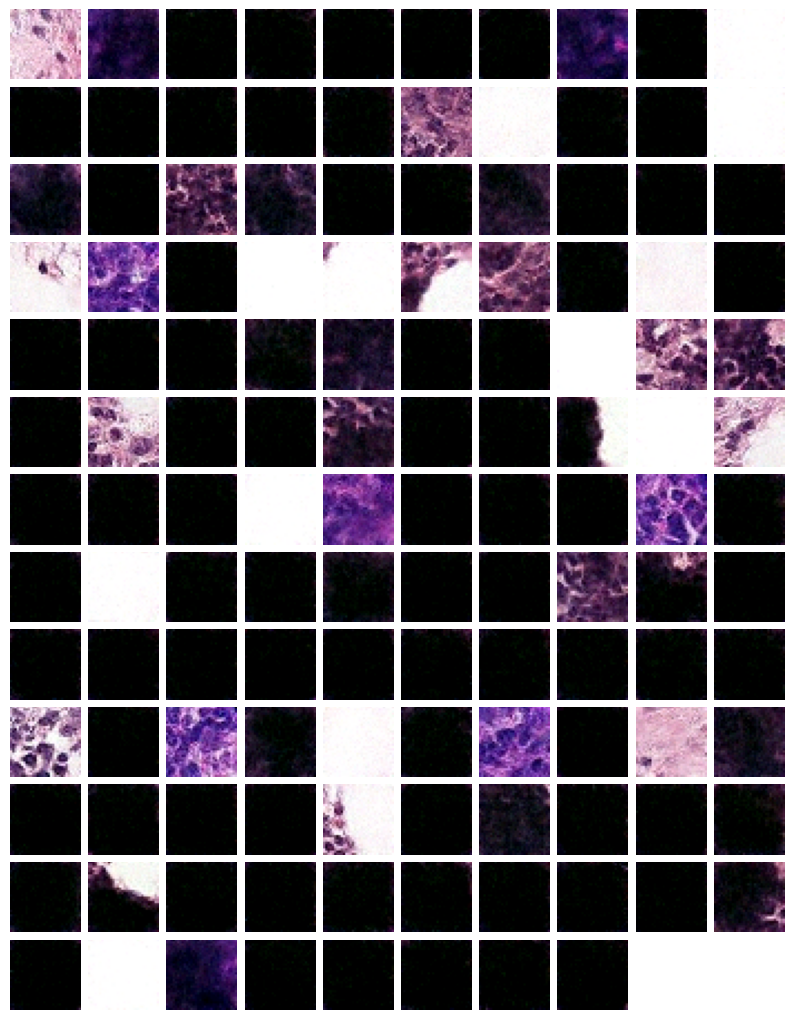

In [136]:
model_dict[model_dict_str].show_images(samples_img) if SAMPLE_MODEL else None

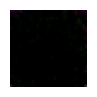

In [ ]:
# Show a random index
batch_idx = 43
model_dict[model_dict_str].show_images(samples_img[batch_idx]) if SAMPLE_MODEL else None

We can also create a gif of the denoising process using all saved timesteps within the timestep dimension of the reverse process:

In [ ]:
reversed_samples = np.array([[model_dict[model_dict_str].reverse_transform(timestep_image) for timestep_image in sample] for sample in samples]) if SAMPLE_MODEL else None

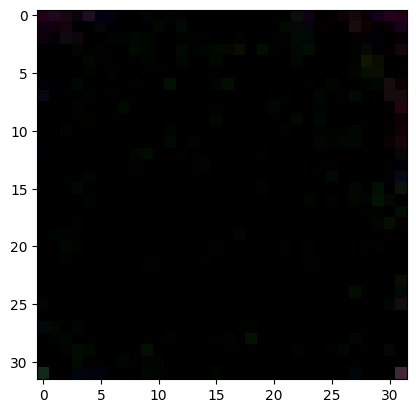

In [ ]:
if SAMPLE_MODEL:
    fig, ax = plt.subplots()
    images = []
    for t in range(model_dict[model_dict_str].timesteps):
        image = plt.imshow(reversed_samples[batch_idx][t], cmap='gray' if eval_dataset.channels == 1 else None, animated=True)
        images.append([image])

    animate = animation.ArtistAnimation(fig, images, interval=10, repeat_delay=1000, blit=True)
    animate.save('diffusion.gif')

In [ ]:
video = animate.to_html5_video() if SAMPLE_MODEL else None
HTML(video) if SAMPLE_MODEL else None

In [ ]:
def plot_reverse_fig(reversed_samples, title:str=None, nrows:int=32, ncols:int=32):
    fig, ax = plt.subplots(nrows, ncols, figsize=(34,34))
    plt.subplots_adjust(wspace=0, hspace=0)

    for idx, img in enumerate(reversed_samples[:,-1]):
        plt.subplot(nrows, ncols, idx+1)
        plt.imshow(img)
        plt.axis('off')

    plt.suptitle(title, y=0.89)

In [ ]:
plot_reverse_fig(reversed_samples=reversed_samples, title='Generated Malignant Images') if SAMPLE_MODEL else None

# Evaluation

Next, the dataset will be evaluated based on two metrics:

1.    Maximum Likelihood
2.    Structural Similarity Score (SSIM)

Where we obtain the score for each set of differently ablated models.

## Likelihood

The following function calculates the average negative log-likelihood (in `PyTorch` convention, `binary_cross_entropy_loss`) for all holdout, evaluation samples. Originally, likelihood estimation is presented as a method of evaluating GANs (as shown in [Eghbal-zadeh, Widmer](https://arxiv.org/pdf/1707.07530.pdf)). In effect, batches of model generated vs. holdout evaluation images are compared to provide a measure of how well generated images "resemble" evaluation images, where

$$\mathrm{BCE} = -\sum_{s,b} \left[y \times \mathrm{log}(p) + (1-y) \times \mathrm{log}(1-p) \right]$$

and

1. $y$ is the evaluation label
2. $p$ is the predicted probability for the input class (if estimated result, sigmoid of the value)
3. $\sum_{s, b}$ over all samples over all batches

In rationale, the underlying distributions of the generated images are compared to that of the evaluation images, and finding the model which minimizes discernable differences selects for the best model, and we attempt to minimize the log likelihood (maximimizing the likelihood).

In [ ]:
@torch.no_grad()
def compute_likelihood(diffusion_model, model_name, dataloader, device):
    total_likelihood = 0
    for batch_idx, data in enumerate(dataloader, 1):
        data = data.to(device)
        
        samples, samples_last_img = diffusion_model.sample_batch(diffusion_model, batch_size=data.shape[0]) ## Sample from model   
        samples = np.array([diffusion_model.reverse_transform(img) for img in samples_last_img]) ## Create a numpy array of reverse_transformed images using the last timestep for all batched
        samples = rearrange(samples, 'b h w c -> b c h w') ## Rearrange from [batch x height x width x channel] in generated images to [batch x channel x height x width] in dataset images
        samples = torch.Tensor(samples).to(device) ## Create torch.Tensor from samples
        
        samples = torch.sigmoid(samples) ## Apply sigmoid to get probabilities from samples
        total_likelihood += F.binary_cross_entropy(samples, data, reduction='mean').item()
        
        is_last_batch = True if len(dataloader) == batch_idx else False

        image_num = batch_idx * dataloader.batch_size if not is_last_batch else len(dataloader.dataset)
        running_avg_likelihood = (total_likelihood / image_num) if not is_last_batch else (total_likelihood / len(dataloader.dataset))
        
        print(f'Model: {model_name} | Batch Index: {batch_idx}/{len(dataloader)} | Image: {image_num}/{len(dataloader.dataset)} | Running Average Likelihood: {running_avg_likelihood}')

    average_likelihood = total_likelihood / len(dataloader.dataset)
    return average_likelihood

## Structural Similarity Index

As proposed in the 2004 paper [Image Quality Assessment: From Error Visibility to
Structural Similarity](https://www.cns.nyu.edu/pub/eero/wang03-reprint.pdf), Structural Similarity Index (or SSIM for short) compares generated images on three different features of *luminance*, *contrast*, and *structure*, where

1. **luminance**: comparing between two images $X$ and $Y$, for pixel values $x$ and $y$ we determine the mean brightness for each using the equation: $\mu_x = \frac{1}{N} \sum^{N}_{i=1}x_i$ (respectively the same for $y$ values), the luminance: $$l(\mathbf{x}, \mathbf{y}) = \frac{x\mu_x\mu_y + C_1}{\mu^2_x+\mu^2_y + C_1}, C_1 = (LK_1)^2$$

2. **contrast**: comparing between two images $X$ and $Y$, for pixel values $x$ and $y$ we determine the standard deviation brightness for each using the equation: $\sigma_x = \left( \frac{1}{N-1} \sum_{i=1}^{N} (x_i - \mu_x)^2 \right)^\frac{1}{2}$ (respectively the same for $y$ values), the contrast: $$c(\mathbf{x}, \mathbf{y}) = \frac{2\sigma_x\sigma_y + C_2}{\sigma_x^2 + \sigma_x^2 + C_2}, C_2 = (LK_2)^2$$

    (where $L = 255$ or the dynamic range of RGB pixel values)

3. **similarity**: comparing between two images $X$ and $Y$ for pixel values $x$ and $y$, the similarity is defined as $$s(\mathbf{x}, \mathbf{y}) = \frac{\sigma_{xy} + C_3}{\sigma_x\sigma_y + C_3}$$ where $\sigma_{xy} = \frac{1}{N-1}\sum^{N}_{i=1}(x_i-\mu_x)(y_i-\mu_y)$ (and $C_3$ to be defined later on)

Finally, $$ \mathrm{SSIM}(\mathbf{x},\mathbf{y}) = [l(\mathbf{x},\mathbf{y})]^\alpha \cdot [c(\mathbf{x},\mathbf{y})]^\beta \cdot [s(\mathbf{x},\mathbf{y})]^\gamma$$

where $\alpha>0, \beta>0, \gamma>0$.

Simplifying by setting $\alpha = \beta = \gamma = 1$ and $C_3 = C_2 / 2$, we obtain:

$$
\mathrm{SSIM}(\mathbf{x},\mathbf{y}) =  \frac{(2\mu_x\mu_y + C_1)(2\sigma_{xy} + C_2)}{(\mu_x^2+\mu_y^2 + C_1)(\sigma_x^2+\sigma_y^2+C_2)}
$$

The rationale being that while generated images can be different from evaluation set images, image classes of histopathological scans have enough discernable similarity between each other in terms of luminence, contrast, and structure that a discernable difference can be discerned between different architectures of machine learning models.

In [ ]:
@torch.no_grad()
def compute_rgb_ssim(diffusion_model, model_name, dataloader, device):
    total_ssim = 0
    for batch_idx, data in enumerate(dataloader, 1):
        data = data.numpy() ## Convert batched images to numpy arrays

        samples, samples_last_img = diffusion_model.sample_batch(diffusion_model, batch_size=data.shape[0]) ## Sample from diffusion model   
        samples = np.array([diffusion_model.reverse_transform(img) for img in samples_last_img]) ## Create a numpy array of reverse_transformed images using the last timestep for all batched
        samples = rearrange(samples, 'b h w c -> b c h w') ## Rearrange from [batch x height x width x channel] in generated images to [batch x channel x height x width] to be consistent with dataset images

        ssim_value = ssim(im1=data, im2=samples, channel_axis=1, gaussian_weights=True, sigma=1.5, use_sample_covariance=False) ## Uses values found in Wang, et al.

        total_ssim += ssim_value ## Add average calculated ssim per channel per batch to total_ssim

        is_last_batch = True if len(dataloader) == batch_idx else False

        image_num = batch_idx * dataloader.batch_size if not is_last_batch else len(dataloader.dataset)
        running_avg_ssim = (total_ssim / image_num) if not is_last_batch else (total_ssim / len(dataloader.dataset))

        print(f'Model: {model_name} | Batch Index: {batch_idx}/{len(dataloader)} | Image: {image_num}/{len(dataloader.dataset)} | Running Average SSIM: {running_avg_ssim}')

    ## Returns the average SSIM score for each channel per image
    return total_ssim / len(dataloader.dataset)

## Evaluation Using Metrics

Here, the dictionary of models created will be used to evaluate scores for each model and saved as a `.csv` file.

The holdout `eval` images will be used to create a `DataLoader` object to compute the scores.

In [ ]:
num_splits = 5

image_size = eval_dataset.image_size
channels = eval_dataset.channels
eval_batch_size = 64
eval_dataset.return_PIL = False

In [ ]:
if EVAL_MODEL:
    for split in range(3, num_splits+1):

        ablation_dict = {}
        for model_name, model in model_dict.items():
            ## Create a temporary dictionary for the current model
            tmp_dict = {}

            ## Set device
            device = 'cuda' if torch.cuda.is_available() else 'cpu'

            ## Compute likelihood and add to tmp_dict
            average_likelihood = compute_likelihood(diffusion_model=model, model_name=model_name, dataloader=eval_loader, device=device)
            print('='*100)
            print(f'Added {model_name}\'s average likelihood to ablation_dict')
            print('='*100)
            tmp_dict['average_likelihood'] = average_likelihood

            ## Compute SSIM score and add to tmp_dict
            average_ssim = compute_rgb_ssim(diffusion_model=model, model_name=model_name, dataloader=eval_loader, device=device)
            print('='*100)
            print(f'Added {model_name}\'s average SSIM to ablation_dict')
            print('='*100)
            tmp_dict['average_ssim'] = average_ssim

            ## Set the ablation_dict key to be the current model's name (block_klass, loss_type) and add to main dictionary
            ablation_dict[model_name] = tmp_dict
        
            json_path = f'./drive/MyDrive/cv-final-project/ablation_study/ablation_eval_results/ablation_dict{split}.json'

            with open(json_path, 'w') as json_file:
                json.dump(ablation_dict, json_file)

## Loading in Ablation Dict

Now we load in each `.json` associated with an `ablation_dict` to view its' contents based on 

In [ ]:
for split in range(1, num_splits+1):
    json_path = f'./drive/MyDrive/cv-final-project/ablation_study/ablation_eval_results/ablation_dict{split}.json'

    with open(json_path) as json_file:
        ablation_dict = json.load(json_file)
    
    ablation_dict = json.dumps(ablation_dict, indent=4)
    print('='*50)
    print(f'ablation_dict{split}')
    print('='*50)
    print(ablation_dict)

## Creating Average `dict`

Next, the average of all splits is take and the `average_ablation_dict` is created of the previously defined dicts

In [ ]:
def process_ablation_dicts(*files):
    # Initialize variables for accumulating results
    total_splits = len(files)
    aggregated_results = {}

    # Loop through each .json file
    for file in files:
        with open(file, 'r') as f:
            data = json.load(f)

        # Accumulate results for each key in the .json file
        for key, value in data.items():

            if key not in aggregated_results:
                aggregated_results[key] = {
                    'average_likelihood': 0,
                    'average_ssim': 0
                }

            aggregated_results[key]['average_likelihood'] += value['average_likelihood']
            aggregated_results[key]['average_ssim'] += value['average_ssim']

    # Calculate per-split average
    for key in aggregated_results:
        aggregated_results[key]['average_likelihood'] /= total_splits
        aggregated_results[key]['average_ssim'] /= total_splits

    return aggregated_results

In [ ]:
files = glob.glob('./drive/MyDrive/cv-final-project/ablation_study/ablation_eval_results/*.json')

split_averaged_ablation_dict = process_ablation_dicts(*files)
split_averaged_ablation_dict = json.dumps(split_averaged_ablation_dict, indent=4)
print(split_averaged_ablation_dict)

We end up choosing `cosine_beta_schedule-no_attention` as the architecture of choice, as the architecture with the lowest `average_likelihood` and highest `average_ssim`


